## Gillespie algorithm for running a 2-group SIR model

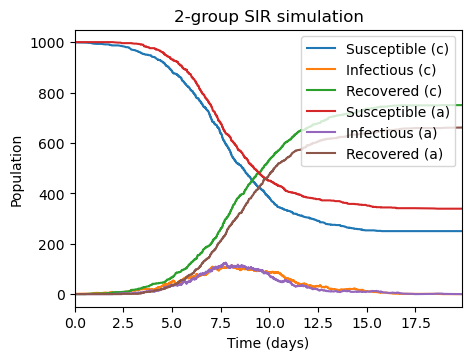

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
b_cc, b_ca, b_ac, b_aa = 1.5, 0.5, 0.5, 1.2 # Infection rates
r_c, r_a = 1, 1 # Recovery rates

init_sc = 999 # initial populations of each group
init_ic = 1
init_rc = 0
init_sa = 1000
init_ia = 0
init_ra = 0
N_c = 1000
N_a = 1000

# Gillespie's algorithm
def gillespie_SIR(S_c, I_c, R_c, S_a, I_a, R_a):
    rates = np.array([
        b_cc * S_c * I_c / N_c + b_ac * S_c * I_a / N_c,  # Infection rate for population c
        b_aa * S_a * I_a / N_a + b_ca * S_a * I_c / N_a,  # Infection rate for population a
        r_c * I_c,                # Recovery rate for population c
        r_a * I_a                # Recovery rate for population a
    ])
    total_rate = np.sum(rates)
    if total_rate == 0:
        return None
    dt = np.random.exponential(scale=1 / total_rate) # sample time until next event
    event = np.random.choice(range(len(rates)), p=rates/total_rate) # determine which event occurred
    if event == 0:
        return (S_c - 1, I_c + 1, R_c, S_a, I_a, R_a), dt # S_c infected
    elif event == 1:
        return (S_c, I_c, R_c, S_a - 1, I_a + 1, R_a), dt # S_a infected
    elif event == 2:
        return (S_c, I_c - 1, R_c + 1, S_a, I_a, R_a), dt # I_c recovered
    else:
        return (S_c, I_c, R_c, S_a, I_a - 1, R_a + 1), dt # I_a recovered

# Simulation function
def simulate_SIR(S0_c, I0_c, R0_c, S0_a, I0_a, R0_a, t_max):
    S_c, I_c, R_c = S0_c, I0_c, R0_c # assign initial populations
    S_a, I_a, R_a = S0_a, I0_a, R0_a
    t = 0
    time_points = [t]
    Sc_values = [S_c] # store these populations in an array
    Ic_values = [I_c]
    Rc_values = [R_c]
    Sa_values = [S_a]
    Ia_values = [I_a]
    Ra_values = [R_a]
    
    while t < t_max:
        result = gillespie_SIR(S_c, I_c, R_c, S_a, I_a, R_a) # run one iteration of the algorithm
        if result is None:
            break
        (S_c, I_c, R_c, S_a, I_a, R_a), dt = result
        t += dt
        time_points.append(t)
        Sc_values.append(S_c) # update the population arrays accordingly
        Ic_values.append(I_c)
        Rc_values.append(R_c)
        Sa_values.append(S_a)
        Ia_values.append(I_a)
        Ra_values.append(R_a)
        
    return time_points, Sc_values, Ic_values, Rc_values, Sa_values, Ia_values, Ra_values

# Run simulation
t_max = 100
time_points, SC, IC, RC, SA, IA, RA = simulate_SIR(init_sc, init_ic, init_rc, init_sa, init_ia, init_ra, t_max)

# Plot results
plt.figure(figsize=(5,3.6))
plt.plot(time_points, SC, label='Susceptible (c)') # plot each group population as desired
plt.plot(time_points, IC, label='Infectious (c)')
plt.plot(time_points, RC, label='Recovered (c)')
plt.plot(time_points, SA, label='Susceptible (a)')
plt.plot(time_points, IA, label='Infectious (a)')
plt.plot(time_points, RA, label='Recovered (a)')

plt.xlim([0, time_points[-1]])
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title('2-group SIR simulation')
plt.legend()
plt.show()


## Plot histograms of any number of simulated outbreak sizes

In [36]:
# Histograms

num_runs = 100
sizes = []
threshold = 200 # treshold becomes more concentrated for smaller R0
outbreaks = 0

for run in range(num_runs):
    time_points, SC, IC, RC, SA, IA, RA = simulate_SIR(init_sc, init_ic, init_rc, init_sa, init_ia, init_ra, t_max)
    total_size = RC[-1]+RA[-1]
    sizes.append(total_size) # sizes of each run
    if total_size >= threshold:
        outbreaks += 1

emp = outbreaks/num_runs # proportion classed as major outbreak

print(emp)

0.45


(0.0, 0.65)

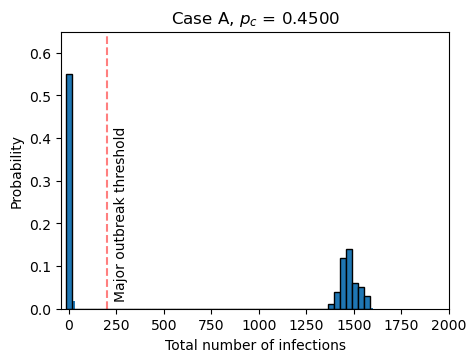

In [37]:
emp = outbreaks/num_runs # proportion classed as major outbreak

plt.figure(figsize=(5,3.6))
counts, bins, patches = plt.hist(sizes, bins = 50, density=True) # set bins = 50 as appropriate
binWidth = bins[1] - bins[0]
plt.bar(bins[:-1], counts*binWidth, binWidth, edgecolor = "black") # ensures y = probability for bin

plt.axvline(x = threshold, color = 'red', linestyle = '--', alpha = 0.5) # outbreak threshold
plt.text(threshold+36, 0.025,'Major outbreak threshold',rotation=90) # outbreak label
plt.title('Case A, $p_c$ = %1.4f' % emp) # ensures empirical probability is shown in the title
plt.xlabel('Total number of infections')
plt.ylabel('Probability')
plt.xlim([-40,2000])
plt.ylim([0, 0.65])

## Using fsolve to solve the system of simultaneous equations

In [38]:
# solving non-linear equations for q_c and q_a

from scipy.optimize import fsolve

Rcc = 2
Rca = 0.75
Rac = 0.75
Raa = 3

def pgf_test(vars): # formula using offspring distribution
    x, y = vars
    eq1 = x-1/(1+Rcc*(1-x)+Rca*(1-y))
    eq2 = y-1/(1+Rac*(1-x)+Raa*(1-y))
    return [eq1, eq2]

x, y =  fsolve(pgf_test, [0]*2)

print(1-x,1-y)

def fsa_test(vars): # formula using first step analysis
    c, a = vars
    eq1 = c-(Rcc*c**2+Rca*c*a+1)/(Rcc+Rca+1)
    eq2 = a-(Rac*c*a+Raa*a**2+1)/(Rac+Raa+1)
    return [eq1, eq2]

c, a = fsolve(fsa_test, [0]*2)

print(1-c,1-a)

0.6481043466776562 0.7273904063124235
0.648104346677508 0.7273904063126617
